In [ ]:
import __init__

import torch
from torch import nn, Tensor, device, cuda
from calas.models.flow import CalasFlowWithRepr
from calas.tools.two_moons import two_moons_rejection_sampling
from calas.models.repr import AE_UNet_Repr, make_flows


dev = device('cuda' if cuda.is_available() else 'cpu')
dty = torch.float32
torch.manual_seed(0)
repr = AE_UNet_Repr(input_dim=2, hidden_sizes=(4,2,4))
# assert repr.embed_dim == 32
assert repr._decoder.out_features == 2

flow = CalasFlowWithRepr(num_classes=2, flows=make_flows(dim=repr.embed_dim), repr=repr).to(device=dev, dtype=dty)

batch_size, n_samp, n_holdout = 100, 1_000, 64
samp = two_moons_rejection_sampling(nsamples=n_samp + n_holdout).to(device=dev, dtype=dty)
samp_class = torch.full((n_samp + n_holdout,), 0.).to(device=dev)

optim = torch.optim.Adam(params=flow.parameters(recurse=True), lr=1e-3)
while True:
    optim.zero_grad()
    perm = torch.randperm(n_samp - n_holdout, device=dev) # Only use first 80 % for train
    loss = flow.loss(input=samp[perm], classes=samp_class[perm])
    loss.backward()
    optim.step()

    # The goal is for the flow to learn to push the class-0 (ID) data towards
    # its conditional mean in the B-space, which is at -3! We want to stop
    # this training if the training data is (at least mostly) close to that.
    b = flow.X_to_B(input=samp[0:batch_size], classes=samp_class[0:batch_size])[0]
    if torch.abs(b.mean() + 3) < .3:
        # Stop training, we're close enough now.
        print(torch.abs(b.mean() + 3).item())
        break

0.24135112762451172


In [28]:
lik_b = lambda b, clz: flow.log_rel_lik_E(embeddings=flow.E_from_B(base=b, classes=clz)[0], classes=clz).detach()

In [29]:
holdout, holdout_clz = samp[n_samp:(n_samp+1)], samp_class[n_samp:(n_samp+1)]
b_batch = flow.X_to_B(input=holdout, classes=holdout_clz)[0].detach()

lik_b(b_batch, holdout_clz),\
b_batch

(tensor([-33.6008], device='cuda:0'),
 tensor([[-2.8806, -2.4794, -2.6176, -2.7978, -2.9074, -2.7362, -2.7954, -2.8289,
          -2.8904, -2.8918]], device='cuda:0'))

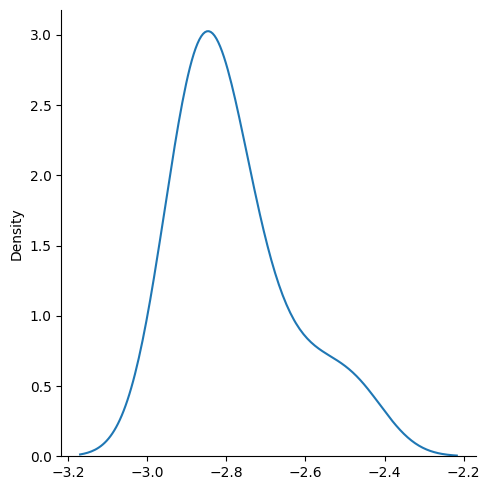

In [30]:
import seaborn as sns

sns.displot(b_batch.flatten().cpu().numpy(), kind='kde')

In [31]:
from torch.distributions.normal import Normal

normal_E = Normal(loc=b_batch.mean(), scale=b_batch.std(), validate_args=True)
normal_E

Normal(loc: -2.7825584411621094, scale: 0.1384783238172531)

In [32]:
normal = Normal(loc=flow.mean_for_class(0), scale=torch.exp(flow.log_scale_for_class(0)), validate_args=True)
normal

Normal(loc: -3.0, scale: 0.5)

In [34]:
b_perfect = normal.icdf(normal_E.cdf(b_batch))

b_batch, b_perfect

(tensor([[-2.8806, -2.4794, -2.6176, -2.7978, -2.9074, -2.7362, -2.7954, -2.8289,
          -2.8904, -2.8918]], device='cuda:0'),
 tensor([[-3.3541, -1.9052, -2.4045, -3.0550, -3.4507, -2.8327, -3.0465, -3.1675,
          -3.3893, -3.3945]], device='cuda:0'))

In [35]:
lik_b(b_perfect, holdout_clz)

tensor([-11.2413], device='cuda:0')

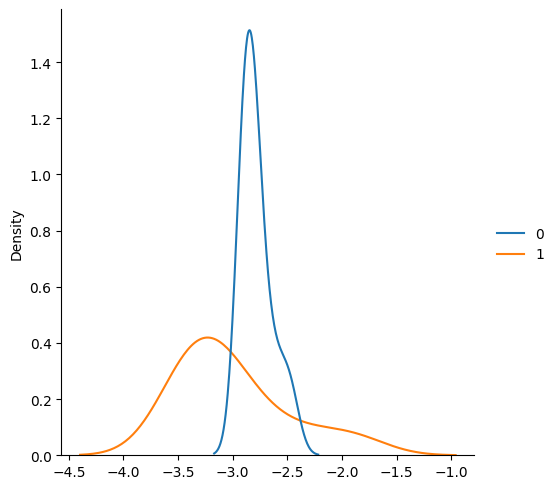

In [ ]:
import numpy as np

sns.displot(np.vstack((
    b_batch.flatten().cpu().numpy(),
    b_perfect.flatten().cpu().numpy()
)).T, kind='kde')

In [69]:
normal_test = Normal(loc=torch.tensor([-3.4], device=dev), scale=torch.tensor([0.8], device=dev))

b_test = normal_test.icdf(normal_E.cdf(b_batch))

b_batch, b_test

(tensor([[-2.8806, -2.4794, -2.6176, -2.7978, -2.9074, -2.7362, -2.7954, -2.8289,
          -2.8904, -2.8918]], device='cuda:0'),
 tensor([[-3.9666, -1.6483, -2.4473, -3.4879, -4.1210, -3.1323, -3.4745, -3.6680,
          -4.0229, -4.0311]], device='cuda:0'))

In [70]:
lik_b(b_test, holdout_clz)

tensor([-16.6143], device='cuda:0')

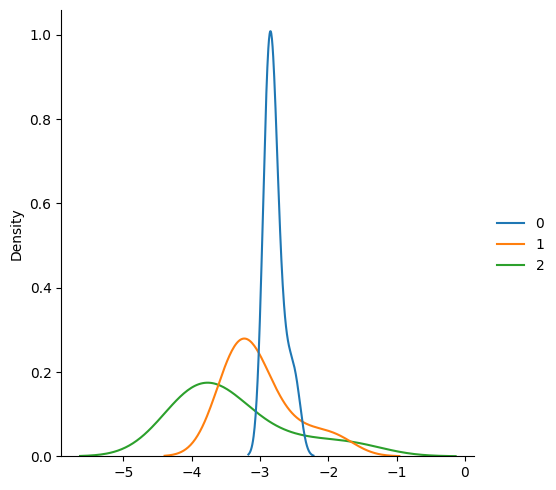

In [71]:

sns.displot(np.vstack((
    b_batch.flatten().cpu().numpy(),
    b_perfect.flatten().cpu().numpy(),
    b_test.flatten().cpu().numpy()
)).T, kind='kde')

In [167]:
temp = b_batch[:, torch.randperm(b_batch.shape[1])]
temp[0,5]=-10

lik_b(temp, clz=holdout_clz), temp

(tensor([-117.4631], device='cuda:0'),
 tensor([[ -2.8289,  -2.9074,  -2.7954,  -2.8904,  -2.8918, -10.0000,  -2.7978,
           -2.4794,  -2.8806,  -2.6176]], device='cuda:0'))

In [ ]:
flow.E_from_B(temp, holdout_clz)

(tensor([[-0.6419, -1.9973, -1.2955, -0.1372, -9.8005,  1.8439,  0.4052,  2.3504,
           0.7484,  0.9763]], device='cuda:0', grad_fn=<IndexSelectBackward0>),
 tensor([16.0535], device='cuda:0', grad_fn=<AddBackward0>))